<a href="https://colab.research.google.com/github/aimalz/CASTORpz/blob/main/July_draft_paper_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**These are the usual preliminaries. The first cell needs to be run. Otherwise, I've saved the catalogs and you can just read them in rather than redefining everything**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from astropy.table import Table
prepend = '/content/drive/MyDrive/Research/CASTORpz/'
unp = Table.read(prepend+"unperturbed_mags.fits")
print(len(unp))

# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install jaxlib #==0.4.16
!pip install jax #==0.4.16

# jaxlib==0.3.22+cuda11.cudnn82

# !pip install jax[cuda]==0.4.17+cuda12.cudnn89 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# !pip install "jax[cuda]"==0.4.16
!nvcc --version

!pip install astropy pzflow corner


from pzflow import Flow
import jax.numpy as jnp
import pandas as pd
import numpy as np
import pickle
import corner
import matplotlib.pyplot as plt
from astropy.table import Table
from pzflow import Flow, FlowEnsemble
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling, ColorTransform, InvSoftplus, RollingSplineCoupling, ShiftBounds

Mounted at /content/drive
698211
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00


In [4]:
cd /content/drive/MyDrive/Research/CASTORpz

/content/drive/MyDrive/Research/CASTORpz


In [ ]:
unp = Table.read(prepend+"unperturbed_mags.fits").to_pandas()#.set_index('ID')
mock = Table.read(prepend+"ext_phot.fits").to_pandas()#.set_index('ID')

In [ ]:
names_phot = ["ID", "photoz",
              "LSST_u_MAG",
              "LSST_g_MAG", "LSST_g_MAGERR",
              "LSST_r_MAG", "LSST_r_MAGERR",
              "LSST_i_MAG", "LSST_i_MAGERR",
              "LSST_z_MAG", "LSST_z_MAGERR",
              "castor_uv_MAG", "castor_uv_MAGERR",
              "castor_u_MAG", "castor_u_MAGERR",
              "castor_g_MAG", "castor_g_MAGERR",
              "Euclid_VIS_MAG",
              'Euclid_Y_MAG','Euclid_J_MAG','Euclid_H_MAG',
              'Roman_106_MAG',
              'Roman_129_MAG','Roman_158_MAG',
              'Roman_184_MAG']



available_os = ["CASTOR-only", "LSST-only", "Euclid-only", #"Roman-only",
"LSST+CASTOR", "Euclid+CASTOR", #"Roman+CASTOR",
"Euclid+LSST", "Euclid+LSST+CASTOR"
]

Roman_os = ["Roman-only", "Roman+CASTOR", "Roman+Euclid+LSST+CASTOR", "Roman+LSST"]

available_os = available_os + Roman_os
print(available_os)

names = available_os

['CASTOR-only', 'LSST-only', 'Euclid-only', 'LSST+CASTOR', 'Euclid+CASTOR', 'Euclid+LSST', 'Euclid+LSST+CASTOR', 'Roman-only', 'Roman+CASTOR', 'Roman+Euclid+LSST+CASTOR', 'Roman+LSST']


In [ ]:
# load data
def getTrueY(test_cat, mag_col_names, y_col_name):
    test_cat = Table(test_cat, masked=True, copy=True)
    # remove nans
    for col in mag_col_names:
        test_cat[col].mask = np.isnan(test_cat[col].data) | test_cat[col].mask
        test_cat = test_cat[~test_cat[col].mask] # then remove nans from test set

    true_y = test_cat[y_col_name]
    return true_y.filled()

In [ ]:
mock_cat = pd.merge(mock, unp[['ID',"Euclid_VIS_MAG"]], on='ID')
CASTOR_baseline = Table.from_pandas(mock_cat)

In [ ]:
# put data in expected format for TLM

LSST_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_u_MAG")
LSST_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAG")
LSST_r_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAG")
LSST_i_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAG")
LSST_z_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAG")
LSST_y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_y_MAG")

# LSST_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_g_MAGERR")
# LSST_r_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_r_MAGERR")
# LSST_i_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_i_MAGERR")
# LSST_z_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="LSST_z_MAGERR")

CASTOR_g_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAG")
CASTOR_u_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAG")
CASTOR_uv_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAG")

# CASTOR_g_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_g_MAGERR")
# CASTOR_u_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_u_MAGERR")
# CASTOR_uv_mag_ERR = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="castor_uv_MAGERR")

Euclid_VIS_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_VIS_MAG")
Euclid_J_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_J_MAG")
Euclid_H_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_H_MAG")
Euclid_Y_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="Euclid_Y_MAG")

# Roman - only a subset of the Roman filters are available?

# Roman_062_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_062_MAG')
# Roman_087_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_087_MAG')
Roman_106_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_106_MAG')

Roman_129_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_129_MAG')
# Roman_146_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_146_MAG')
Roman_158_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_158_MAG')

Roman_184_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_184_MAG')
# Roman_213_mag = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name='Roman_213_MAG')

ID = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="ID")
z_true = getTrueY(test_cat=CASTOR_baseline, mag_col_names=names_phot, y_col_name="photoz")

In [ ]:
which_cols = {}
which_cols['LSST'] = {'r': LSST_r_mag,
                             'u-g': LSST_u_mag - LSST_g_mag,
                             'g-r': LSST_g_mag - LSST_r_mag,
                             'r-i': LSST_r_mag - LSST_i_mag,
                             'i-z': LSST_i_mag - LSST_z_mag,
                             'z-y': LSST_z_mag - LSST_y_mag,
                      }
which_cols['CASTOR'] = {'g': CASTOR_g_mag,
                             'uv-u': CASTOR_uv_mag - CASTOR_u_mag,
                             'uc-g': CASTOR_u_mag - CASTOR_g_mag}
which_cols['Roman'] = {'106': Roman_106_mag,
                             '129 - 106': Roman_129_mag - Roman_106_mag,
                             '158-129': Roman_158_mag - Roman_129_mag,
                             '184-158': Roman_184_mag - Roman_158_mag}
which_cols['Euclid'] = { 'v': Euclid_VIS_mag,
                             'v-y': Euclid_VIS_mag - Euclid_Y_mag,
                             'y-j': Euclid_Y_mag - Euclid_J_mag,
                             'j-h': Euclid_J_mag - Euclid_H_mag}

In [ ]:
test_catalogs = {}
test_catalogs['LSST-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST']}).set_index('CASTOR_ID').dropna()
test_catalogs['CASTOR-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid-only'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid']}).set_index('CASTOR_ID').dropna()
test_catalogs['LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Euclid']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+Roman'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+LSST'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Euclid'], **which_cols['Roman'], **which_cols['LSST']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+LSST+CASTOR'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()
test_catalogs['Roman+Euclid+LSST+CASTOR-any'] = pd.DataFrame({'CASTOR_ID': ID, 'z_true': z_true, **which_cols['Roman'], **which_cols['LSST'], **which_cols['Euclid'], **which_cols['CASTOR']}).set_index('CASTOR_ID').dropna()

In [ ]:
LSST_mask = (LSST_u_mag < 25.6) & (LSST_g_mag < 26.9) & (LSST_r_mag < 26.9) & (LSST_i_mag < 26.4) & (LSST_z_mag < 25.6) & (LSST_y_mag < 24.8) #https://www.lsst.org/scientists/keynumbers
CASTOR_mask = (CASTOR_g_mag < 27.5) & (CASTOR_u_mag < 27.5) & (CASTOR_uv_mag < 27.6)
Roman_mask = (Roman_106_mag < 26.7) & (Roman_129_mag < 26.7) & (Roman_158_mag < 26.7) & (Roman_184_mag < 26.7) # https://www.stsci.edu/roman/surveys-and-programs
Euclid_mask = (Euclid_VIS_mag < 26.2) & (Euclid_J_mag < 24.5) & (Euclid_H_mag < 24.5) & (Euclid_Y_mag < 24.5) #https://arxiv.org/pdf/2108.01201

masks = {}

masks['LSST-only'] = LSST_mask
masks['CASTOR-only'] = CASTOR_mask
masks['Roman-only'] = Roman_mask
masks['Euclid-only'] = Euclid_mask

masks['LSST+CASTOR'] = LSST_mask & CASTOR_mask
masks['Euclid+CASTOR'] = Euclid_mask & CASTOR_mask
masks['Roman+CASTOR'] = Roman_mask & CASTOR_mask
masks['Euclid+LSST'] = Euclid_mask & LSST_mask
masks['Roman+LSST'] = Roman_mask & LSST_mask
masks['Euclid+LSST+CASTOR'] = Euclid_mask & LSST_mask & CASTOR_mask

masks['Roman+Euclid+LSST+CASTOR'] = Roman_mask & Euclid_mask & LSST_mask & CASTOR_mask
masks['Roman+Euclid+CASTOR'] = Roman_mask & Euclid_mask & CASTOR_mask
masks['Roman+LSST'] = Roman_mask & LSST_mask
masks['Roman+Euclid+LSST'] = Roman_mask & Euclid_mask & LSST_mask
masks['Euclid+Roman'] = Euclid_mask & Roman_mask

masks['Roman+LSST+CASTOR'] = Roman_mask & LSST_mask & CASTOR_mask
masks['Roman+Euclid+LSST+CASTOR-any'] = Roman_mask + LSST_mask + Euclid_mask + CASTOR_mask

In [2]:
import scipy.stats as stats

In [ ]:
catalogs = test_catalogs
available_os = list(test_catalogs.keys())

# available_os = ['LSST-only',
#                 'Roman-only',
#                 'CASTOR-only',
#                 'Euclid-only',
#                 'Euclid+Roman',
#                 'Roman+Euclid+LSST+CASTOR',
#                 'LSST+CASTOR',
#                 'Euclid+LSST']


# # for os in available_os:
# #   catalogs[os] = catalogs[os][((np.abs(stats.zscore(catalogs[os])) < 3).all(axis=1)) & masks[os]]

# catalogs = test_catalogs

# for os in available_os:
#   catalogs[os] = catalogs[os][((np.abs(stats.zscore(catalogs[os])) < 3).all(axis=1)) & masks['Roman+Euclid+LSST+CASTOR-any']]

# false_mask = np.full(len(catalogs['LSST-only'][masks['Roman+Euclid+LSST+CASTOR']]), False)
# false_mask[0:90000] = True

# np.random.shuffle(false_mask)

for os in available_os:
  print(os)
  # catalogs[os] = catalogs[os][masks['Roman+Euclid+LSST+CASTOR']][false_mask]
  catalogs[os] = catalogs[os][masks[os]]
  catalogs[os] = catalogs[os][(np.abs(stats.zscore(catalogs[os])) < 5).all(axis=1)]

LSST-only
CASTOR-only
Roman-only
Euclid-only
LSST+CASTOR
Euclid+CASTOR
Roman+CASTOR
Euclid+LSST
Roman+LSST
Euclid+Roman
Roman+LSST+CASTOR
Roman+Euclid+CASTOR
Euclid+LSST+CASTOR
Roman+Euclid+LSST
Roman+Euclid+LSST+CASTOR
Roman+Euclid+LSST+CASTOR-any


In [ ]:
with (open(f"catalogs.pkl", 'wb')) as openfile:
  pickle.dump(catalogs, openfile)

**HERE is where you read the catalog back in**

In [46]:
with (open(f"catalogs.pkl", 'rb')) as openfile:
    catalogs = pd.read_pickle(openfile)



In [ ]:
catalogs.keys()

In [6]:
available_os = ['LSST-only',
                'Roman-only',
                'CASTOR-only',
                'Euclid-only',
                'Euclid+Roman',
                'Roman+Euclid+LSST+CASTOR',
                'LSST+CASTOR',
                'Euclid+LSST',
                'Euclid-only',
                'Euclid+CASTOR']

# Roman + CASTOR needs to be retrained with the new uc-g CASTOR column names to eliminate redundancy with LSST

# available_os = ['Euclid+CASTOR']

In [ ]:
# flows = {}
# just_tav = {}
# for os in available_os:
#   flows[os] = FlowEnsemble(file=f"July_12_runs/pzflow_ensemble_for_{os}.pkl")
#   print(os)
#   just_tav[os] = flows[os].log_prob(catalogs[os], returnEnsemble=True)
#   with (open(f"tav_cat_{os}.pkl", 'wb')) as openfile:
#     pickle.dump(just_tav[os], openfile)

LSST-only
Roman-only
CASTOR-only
Euclid-only
Euclid+Roman
Roman+Euclid+LSST+CASTOR
LSST+CASTOR
Euclid+LSST
Euclid-only
Euclid+CASTOR


**Then run this to read in the log_prob (tav - H(z))**

In [7]:
just_tav = {}
for os in available_os:
  # print(os)
  with (open(f"July_12_runs/tav_cat_{os}.pkl", 'rb')) as openfile:
    just_tav[os] = pd.read_pickle(openfile)

In [8]:
flows = {}
for os in available_os:
  flows[os] = FlowEnsemble(file=f"July_12_runs/pzflow_ensemble_for_{os}.pkl")

In [ ]:
import scipy.stats as sps

**This part makes the redshift binned figure**

In [ ]:
def compute_milb(just_tav, available_os):

  all_tlm = {}
  all_milb = {}
  all_ent = {}
  is_inf_mask = {}

  print(available_os)

  for os in available_os:
      # print(os_names[os])
      # load the photometric catalog for this os
    cat = catalogs[os]
    # print(cat.shape)

    # Computing the entropy H(z)
    b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy


    # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = just_tav[os]
    # print(np.sum(np.isinf(milb)))
    # print(np.sum(np.isnan(milb)))
    # print(np.shape(milb[0,:]))
      # print(milb)
    all_milb[os] = np.array(milb)
      # print(np.shape(all_milb[os]))
    all_tlm[os] = milb.mean(axis=1) + entropy
    is_inf_mask[os] = np.isinf(all_tlm[os])
    all_tlm[os] = all_tlm[os][~np.isinf(all_tlm[os])]
    # print(np.sum(np.isinf(all_tlm[os])))

    # print('shape is: ')
    # print(np.shape(all_tlm[os]))
  return all_tlm, is_inf_mask

In [ ]:
# entropy term

def bin_in_redshift(all_tlm, inf_mask):
  zbins = np.linspace(0, 3, 100)
  avgtav = {}
  errtav = {}
  # for os in available_os:
  for os in available_os:
    print(os)
    plotran = np.empty_like(zbins)
    ploterr = np.empty_like(zbins)
    # print(catalogs[os].columns)
    # print(np.shape(catalogs[os]))

    if 'logprob' not in catalogs[os].columns.values:
      catalogs[os] = catalogs[os][~inf_mask[os]]
      catalogs[os]['logprob'] = all_tlm[os]

      # print(catalogs[os].columns)

      # print('shape is: ')

      # print(np.shape(catalogs[os]))

    print(all_tlm[os])
    for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      print(zmax)
      subset = catalogs[os][(catalogs[os]['z_true'] >= zmin) & (catalogs[os]['z_true'] < zmax)]
      # print((zmin, len(subset), zmax))
      vals = subset['logprob']
      mean = np.mean(subset['logprob'])
      # mean = np.mean(vals[vals >   -3])
      # print(mean)
      # std = np.std(vals[vals > -3])
      std = np.std(subset['logprob'])
      plotran[i] = mean
      ploterr[i] = std #len(vals))

    avgtav[os] = plotran
    errtav[os] = ploterr

  return avgtav, errtav

In [ ]:
all_tlm, is_inf_mask = compute_milb(just_tav, available_os)

avgtav, errtav = bin_in_redshift(all_tlm, is_inf_mask)

LSST-only
0
-1.0256441732872812
Euclid-only
0
-0.18921197950839996
Roman-only
0
0.25433310866355896
CASTOR-only
0
-0.4188786447048187
LSST+CASTOR
0
0.1483408510684967
Euclid+Roman
0
2.716803e-318
Euclid+LSST
0
6.61950246465447e-310
Roman+Euclid+LSST+CASTOR
0
-0.4604508876800537


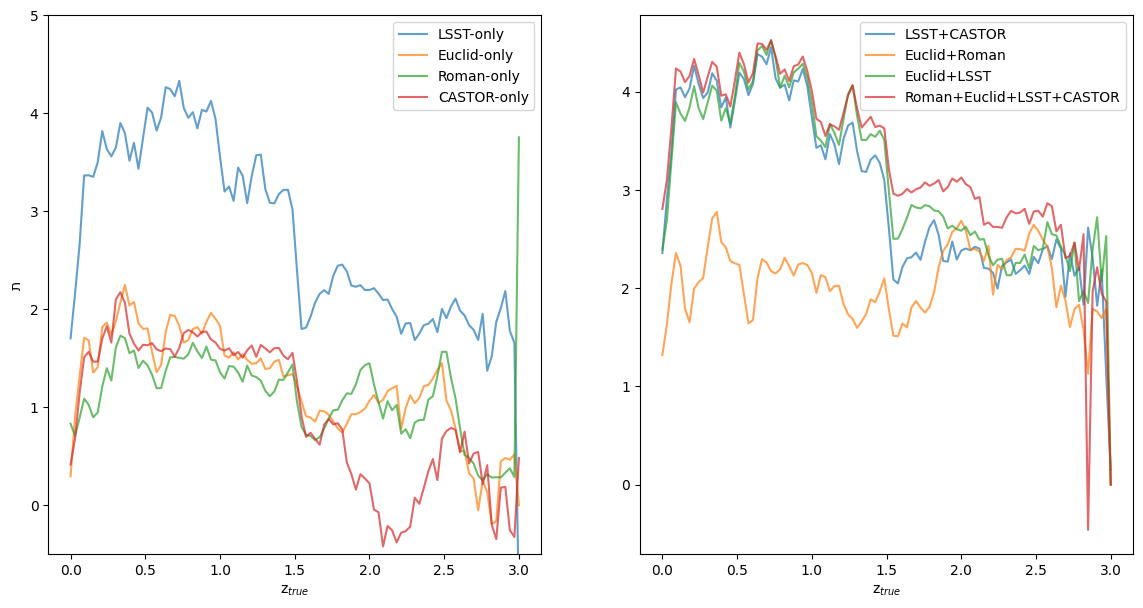

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (14, 7))

zbins = np.linspace(0, 3, 100)

plt_os_left = ['LSST-only',
               'Euclid-only',
               'Roman-only',
               'CASTOR-only']

plt_os_right = ['LSST+CASTOR',
          'Euclid+Roman',
          'Euclid+LSST',
          'Roman+Euclid+LSST+CASTOR']

for os in plt_os_left:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
  # ax[1].plot(zbins, errtav[os], label=os, alpha = 0.7)
  # ax[2].plot(zbins, binned_variance[os], label =os, alpha = 0.7)

for os in plt_os_right:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  ax[1].plot(zbins, avgtav[os], label=os, alpha=0.7)

# ax[0].set_ylim(-10, 5)
# ax[0].legend(fontsize = 8)
ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-0.5, 5)
ax[0].legend()

# ax[0].legend(fontsize = 8)
ax[1].set_xlabel('z$_{true}$')
ax[1].legend()
# ax[1].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_s$')
# ax[1].set_ylim(-0.5, 2)

# ax[2].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_E$')
# ax[2].set_xlabel('z$_{true}$')
# ax[2].set_ylim(-0.5, 2)

# plt.savefig('redshift_binned_with_uncertainty_same_scales.png')
plt.show()

**This part makes the uncertainty figure**

In [ ]:
def compute_milb_ensemble(just_tav, available_os):

  all_tlm = {}
  all_milb = {}
  all_ent = {}
  is_inf_mask = {}

  print(available_os)

  for os in available_os:
      # print(os_names[os])
      # load the photometric catalog for this os
    cat = catalogs[os]
    # print(cat.shape)

    # Computing the entropy H(z)
    b = sps.mstats.mquantiles(z_true, np.linspace(0,1,101, endpoint=True))

    pz = sps.rv_histogram(np.histogram(z_true, bins=b))
    entropy = pz.entropy()
    # just checking that this isn't discrete entropy and that binning doesn't need to match anything else
    # testent = sum(-1 * pz.logpdf(b_centers) * pz.pdf(b_centers) * db)
    # print(entropy - testent)
    all_ent[os] = entropy


    # Computing lower bound
    # all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = just_tav[os]
    # print(np.sum(np.isinf(milb)))
    # print(np.sum(np.isnan(milb)))
    # print(np.shape(milb[0,:]))
      # print(milb)
    all_milb[os] = np.array(milb)
      # print(np.shape(all_milb[os]))
    all_tlm[os] = all_milb[os] + entropy
    is_inf_mask[os] = np.isinf(all_tlm[os])
    # all_tlm[os] = all_tlm[os][~np.isinf(all_tlm[os])]
    # print(np.sum(np.isinf(all_tlm[os])))

    # print('shape is: ')
    # print(np.shape(all_tlm[os]))
  return all_tlm, is_inf_mask

In [ ]:
all_tlm, is_inf_mask = compute_milb_ensemble(just_tav, available_os)

epistemic_variance = {}
redshifts = {}

for os in available_os:
  epistemic_variance[os] = all_tlm[os].std(axis=1)
  redshifts[os] = catalogs[os]['z_true']

binned_variance = {}

for os in available_os:
  print(epistemic_variance[os].shape)
  print(redshifts[os].shape)

  ploterr = np.empty_like(zbins)
  for i, zmin in enumerate(zbins[:-1]):
      zmax = zbins[i+1]
      ploterr[i] = np.mean(epistemic_variance[os][(redshifts[os] >=zmin) & (redshifts[os] < zmax)])

      binned_variance[os] = ploterr

['LSST-only', 'Roman-only', 'CASTOR-only', 'Euclid-only', 'Euclid+Roman', 'Roman+Euclid+LSST+CASTOR', 'LSST+CASTOR', 'Euclid+LSST', 'Euclid-only']


<ipython-input-47-2c69b1faeef8>:19: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  pz = sps.rv_histogram(np.histogram(z_true, bins=b))


(116127,)
(116127,)
(360862,)
(360862,)
(225481,)
(225481,)
(152739,)
(152739,)
(152240,)
(152240,)
(96430,)
(96430,)
(103343,)
(103343,)
(108057,)
(108057,)
(152739,)
(152739,)


LSST-only
0
-1.0256441732872812
Euclid-only
0
-0.18921197950839996
Roman-only
0
0.25433310866355896
CASTOR-only
0
-0.4188786447048187
LSST+CASTOR
0
0.1483408510684967
Euclid+Roman
0
2.716803e-318
Euclid+LSST
0
6.61950246465447e-310
Roman+Euclid+LSST+CASTOR
0
-0.4604508876800537


Text(0, 0.5, '$\\sigma$ (ת)$_E$')

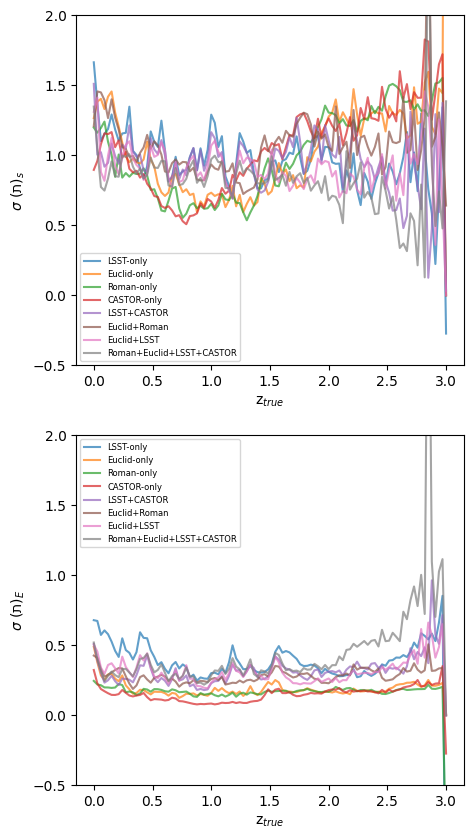

In [ ]:
fig, ax = plt.subplots(2,1, figsize = (5, 10))

zbins = np.linspace(0, 3, 100)

plt_os = ['LSST-only',
               'Euclid-only',
               'Roman-only',
               'CASTOR-only',
               'LSST+CASTOR',
              'Euclid+Roman',
              'Euclid+LSST',
              'Roman+Euclid+LSST+CASTOR']

for os in plt_os:
  print(os)
  print(np.sum(np.isinf(avgtav[os])))
  print(np.min(avgtav[os]))
  # ax[0].plot(zbins, avgtav[os], label=os, alpha=0.7)
  ax[0].plot(zbins, errtav[os], label=os, alpha = 0.7)
  ax[1].plot(zbins, binned_variance[os], label =os, alpha = 0.7)

# for os in plt_os_right:
#   print(os)
#   print(np.sum(np.isinf(avgtav[os])))
#   print(np.min(avgtav[os]))
#   ax[1].plot(zbins, avgtav[os], label=os, alpha=0.7)

# ax[0].set_ylim(-10, 5)
# ax[0].legend(fontsize = 8)
ax[0].set_xlabel('z$_{true}$')
ax[0].set_ylabel(chr(0x05ea))
ax[0].set_ylim(-0.5, 2)
ax[0].legend(fontsize=6)

# ax[0].legend(fontsize = 8)
ax[1].set_xlabel('z$_{true}$')
ax[1].legend(fontsize=6)
ax[1].set_ylim(-0.5, 2)
ax[0].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_s$')
# ax[1].set_ylim(-0.5, 2)

ax[1].set_ylabel('$\sigma$ (' + chr(0x05ea) +')$_E$')

**This makes the new version of Figure 2 - the CDF plots and point-wise information gain figure**

I need to train one more Euclid+CASTOR model which is not saved and read back in properly above. I would just ignore parts that make reference to it if you're focused on polishing the figures - I'll get those last ensembles trained and added in as soon as I'm back to the US.

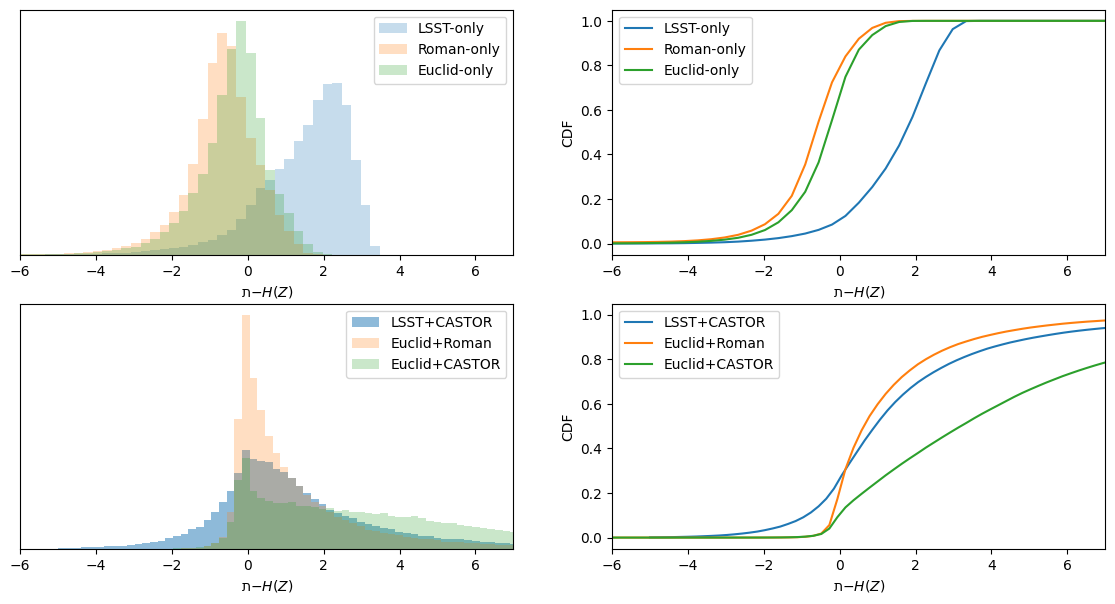

In [ ]:
tav = just_tav

fig, ax = plt.subplots(2, 2, figsize=(14, 7))#, sharex=True)
delta_tav_agg = []
# which_plt = 0
# for os in ['LSST-only', 'Roman-only', 'Euclid-only']:
#   ax[which_plt].hist(tav_cats[os]['z_true'], alpha=0.25, label=os[:-5], density=True, bins=100)
#   ax[which_plt].legend()
#   ax[which_plt].set_xlim(0, 5)
#   ax[which_plt].set_xlabel(r'$z$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
#   ax[which_plt].set_yticks([])

for os in ['LSST-only', 'Roman-only', 'Euclid-only']:
  delta_tav_agg.append(tav[os].mean(axis=1))
  ax[0,0].hist(tav[os].mean(axis=1), alpha=0.25, label=os, density=True, bins=np.linspace(-20, 5, 100))
  ax[0,0].legend()
  ax[0,0].set_xlim(-6, 7)
  ax[0,0].set_xlabel(chr(0x05ea)+r'$-H(Z)$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  ax[0,0].set_yticks([])
which_plt = 1

for os in ['LSST-only', 'Roman-only', 'Euclid-only']:
  delta_tav_agg.append(tav[os].mean(axis=1))
  xran = np.linspace(-20, 15, 100)
  to_plot = sps.ecdf(tav[os].mean(axis=1)).cdf.evaluate(xran)
  ax[0,1].plot(xran, to_plot, label=os)
  ax[0,1].legend()
  ax[0,1].set_xlim(-6, 7)
  ax[0,1].set_xlabel(chr(0x05ea)+r'$-H(Z)$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
  # ax[which_plt].set_yticks([])
  ax[0,1].set_ylabel('CDF')

common_indices = catalogs['LSST+CASTOR'].index.intersection(catalogs['LSST-only'].index)

tav['LSST-only'] = flows['LSST-only'].log_prob(catalogs['LSST-only'].loc[common_indices], returnEnsemble = True)
tav['LSST+CASTOR'] = flows['LSST+CASTOR'].log_prob(catalogs['LSST+CASTOR'].loc[common_indices], returnEnsemble = True)

common_indices = catalogs['Euclid+Roman'].index.intersection(catalogs['Euclid-only'].index)

tav['Euclid-only'] = flows['Euclid-only'].log_prob(catalogs['Euclid-only'].loc[common_indices], returnEnsemble = True)
tav['Euclid+Roman'] = flows['Euclid+Roman'].log_prob(catalogs['Euclid+Roman'].loc[common_indices], returnEnsemble = True)

common_indices = catalogs['Euclid+CASTOR'].index.intersection(catalogs['Euclid-only'].index)

tav['Euclid-only2'] = flows['Euclid-only'].log_prob(catalogs['Euclid-only'].loc[common_indices], returnEnsemble = True) # this is where the bug is here, common_indices changes but tav['Euclid-only'] shouldn't for the next cell to work properly
tav['Euclid+CASTOR'] = flows['Euclid+CASTOR'].log_prob(catalogs['Euclid+CASTOR'].loc[common_indices], returnEnsemble = True)

delta_tav_agg = []

delta_tav_agg = tav['LSST-only'].mean(axis=1)
delta_tav_agg = np.exp(tav['LSST+CASTOR'].mean(axis=1)) * (tav['LSST+CASTOR'].mean(axis=1) - delta_tav_agg)

ax[1,0].hist(delta_tav_agg, alpha=0.5, density=True, bins=np.linspace(-5, 15, 100), label = 'LSST+CASTOR')

delta_tav_agg = tav['Euclid-only'].mean(axis=1)
delta_tav_agg = np.exp(tav['Euclid+Roman'].mean(axis=1)) * (tav['Euclid+Roman'].mean(axis=1) - delta_tav_agg)

ax[1,0].hist(delta_tav_agg, alpha=0.25, density=True, bins=np.linspace(-5, 15, 100), label = 'Euclid+Roman')

delta_tav_agg = tav['Euclid-only2'].mean(axis=1)
delta_tav_agg = np.exp(tav['Euclid+CASTOR'].mean(axis=1)) * (tav['Euclid+CASTOR'].mean(axis=1) - delta_tav_agg)

ax[1,0].hist(delta_tav_agg, alpha=0.25, density=True, bins=np.linspace(-5, 15, 100), label = 'Euclid+CASTOR')

ax[1,0].legend()
ax[1,0].set_xlim(-6, 7)
ax[1,0].set_xlabel(chr(0x05ea)+r'$-H(Z)$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
ax[1,0].set_yticks([])

delta_tav_agg = tav['LSST-only'].mean(axis=1)
delta_tav_agg = np.exp(tav['LSST+CASTOR'].mean(axis=1)) * (tav['LSST+CASTOR'].mean(axis=1) - delta_tav_agg)

xran = np.linspace(-5, 15, 100)
to_plot = sps.ecdf(delta_tav_agg).cdf.evaluate(xran)
ax[1,1].plot(xran, to_plot, label='LSST+CASTOR')

delta_tav_agg = tav['Euclid-only'].mean(axis=1)
delta_tav_agg = np.exp(tav['Euclid+Roman'].mean(axis=1)) * (tav['Euclid+Roman'].mean(axis=1) - delta_tav_agg)

xran = np.linspace(-6, 15, 100)
to_plot = sps.ecdf(delta_tav_agg).cdf.evaluate(xran)
ax[1,1].plot(xran, to_plot, label='Euclid+Roman')

delta_tav_agg = tav['Euclid-only2'].mean(axis=1)
delta_tav_agg = np.exp(tav['Euclid+CASTOR'].mean(axis=1)) * (tav['Euclid+CASTOR'].mean(axis=1) - delta_tav_agg)

xran = np.linspace(-6, 15, 100)
to_plot = sps.ecdf(delta_tav_agg).cdf.evaluate(xran)
ax[1,1].plot(xran, to_plot, label='Euclid+CASTOR')

ax[1,1].set_xlim(-6, 7)
ax[1,1].set_xlabel(chr(0x05ea)+r'$-H(Z)$') #r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
# ax[which_plt].set_yticks([])
ax[1,1].set_ylabel('CDF')

ax[1,1].legend()

In [ ]:
delta_tav_agg

Array([10.028802  ,  6.383808  ,  4.2241845 , ..., -0.01888924,
        3.507806  , -0.5121518 ], dtype=float32)

In [9]:
# now want to look at the top 0.1% of the improvement in the KLD for each survey combination
tav = just_tav

delta_tav_agg = {}

delta_tav_os = ['LSST+CASTOR',
                'Roman+Euclid',
                'Euclid+CASTOR']

common_indices = catalogs['LSST+CASTOR'].index.intersection(catalogs['LSST-only'].index)

tav['LSST-only'] = flows['LSST-only'].log_prob(catalogs['LSST-only'].loc[common_indices], returnEnsemble = True)
tav['LSST+CASTOR'] = flows['LSST+CASTOR'].log_prob(catalogs['LSST+CASTOR'].loc[common_indices], returnEnsemble = True)

delta_tav_agg['LSST+CASTOR'] = tav['LSST-only'].mean(axis=1)
delta_tav_agg['LSST+CASTOR'] = np.exp(tav['LSST+CASTOR'].mean(axis=1)) * (tav['LSST+CASTOR'].mean(axis=1) - delta_tav_agg['LSST+CASTOR'])

common_indices = catalogs['Euclid+Roman'].index.intersection(catalogs['Euclid-only'].index)

tav['Euclid-only'] = flows['Euclid-only'].log_prob(catalogs['Euclid-only'].loc[common_indices], returnEnsemble = True)
tav['Euclid+Roman'] = flows['Euclid+Roman'].log_prob(catalogs['Euclid+Roman'].loc[common_indices], returnEnsemble = True)

delta_tav_agg['Euclid+Roman'] = tav['Euclid-only'].mean(axis=1)
delta_tav_agg['Euclid+Roman'] = np.exp(tav['Euclid+Roman'].mean(axis=1)) * (tav['Euclid+Roman'].mean(axis=1) - delta_tav_agg['Euclid+Roman'])

common_indices = catalogs['Euclid+CASTOR'].index.intersection(catalogs['Euclid-only'].index)

tav['Euclid-only2'] = flows['Euclid-only'].log_prob(catalogs['Euclid-only'].loc[common_indices], returnEnsemble = True) # this is where the bug is here, common_indices changes but tav['Euclid-only'] shouldn't for the next cell to work properly
tav['Euclid+CASTOR'] = flows['Euclid+CASTOR'].log_prob(catalogs['Euclid+CASTOR'].loc[common_indices], returnEnsemble = True)

delta_tav_agg['Euclid+CASTOR'] = tav['Euclid-only2'].mean(axis=1)
delta_tav_agg['Euclid+CASTOR'] = np.exp(tav['Euclid+CASTOR'].mean(axis=1)) * (tav['Euclid+CASTOR'].mean(axis=1) - delta_tav_agg['Euclid+CASTOR'])

In [10]:
delta_tav_dict, kld_lo, kld_hi = {}, {}, {}

for i, os in enumerate(['LSST+CASTOR', 'Euclid+Roman', 'Euclid+CASTOR']):
  kld_lo[os] = np.percentile(delta_tav_agg[os], 0.1)
  kld_hi[os] = np.percentile(delta_tav_agg[os], 99.9)
  print(os, kld_lo[os], kld_hi[os])

LSST+CASTOR -4.943881067276001 26.723331951141983
Euclid+Roman -1.2900155398845672 15.686656657220338
Euclid+CASTOR -1.4289024938344956 39.84955825805679


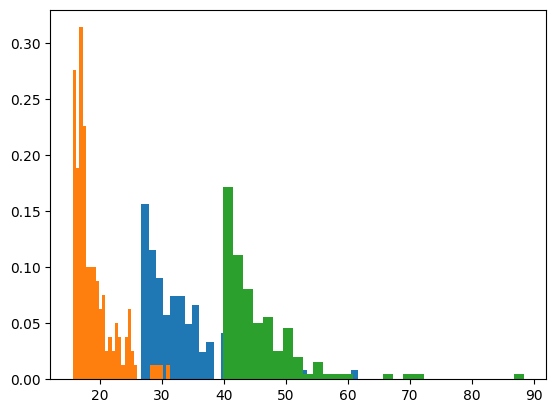

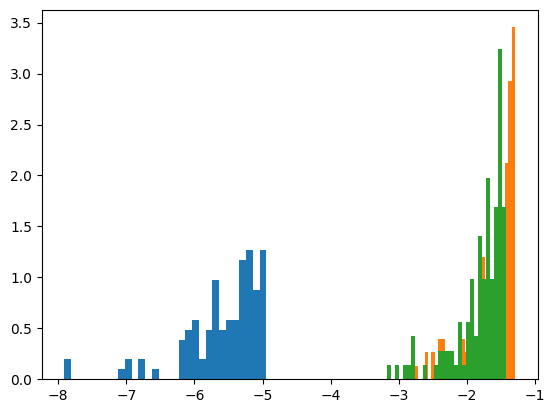

In [78]:
for os in ['LSST+CASTOR', 'Euclid+Roman', 'Euclid+CASTOR']:
  plt.hist(delta_tav_agg[os][delta_tav_agg[os] >= kld_hi[os]], bins = 30, density=True)

plt.show()

for os in ['LSST+CASTOR', 'Euclid+Roman', 'Euclid+CASTOR']:
  plt.hist(delta_tav_agg[os][delta_tav_agg[os] <= kld_lo[os]], bins = 30, density=True)

In [11]:
improved = {}
worsened = {}
improved_indexes = {}
worsened_indexes = {}

for i, os in enumerate(['LSST+CASTOR', 'Euclid+Roman', 'Euclid+CASTOR']):
  improved[os] = delta_tav_agg[os][delta_tav_agg[os] >= kld_hi[os]]
  # print('improved for {}'.format(os))
  improved_indexes[os] = np.where(delta_tav_agg[os] >= kld_hi[os])
  # improved[os] = delta_tav_dict[os][delta_tav_dict[os] >= 10.]
  # print('least improved for {}'.format(os))
  worsened[os] = delta_tav_agg[os][delta_tav_agg[os] <= kld_lo[os]]
  worsened_indexes[os] = np.where(delta_tav_agg[os] >= kld_lo[os])

Array([28.789743, 38.19563 , 28.5812  , 35.1009  , 32.72828 , 33.415432,
       27.255419, 26.761179, 39.631187, 29.345558, 30.247213, 31.298557,
       29.096746, 28.302969, 61.64833 , 30.124046, 33.053047, 27.543152,
       35.561604, 29.48117 , 27.278727, 32.323704, 28.180822, 29.602207,
       31.447985, 41.521763, 41.011086, 30.289904, 28.564627, 30.888071,
       40.29634 , 33.650883, 32.016594, 34.83401 , 28.724134, 29.471231,
       28.288387, 34.66401 , 29.097576, 33.17514 , 26.970774, 31.937113,
       30.192038, 36.696045, 37.8103  , 36.467342, 29.736145, 28.130812,
       26.938515, 35.341297, 39.685352, 34.197258, 40.49073 , 27.18774 ,
       31.02809 , 52.12353 , 27.807247, 30.144173, 47.59343 , 33.03224 ,
       27.64276 , 31.824957, 33.0263  , 28.898125, 27.10555 , 55.510124,
       28.967478, 32.27716 , 27.930136, 32.09397 , 26.934559, 29.649939,
       27.736574, 28.326632, 30.948906, 26.744036, 27.798716, 36.124626,
       37.978416, 33.208687, 52.686726, 34.305836, 

In [ ]:
for i,os in enumerate(['LSST+CASTOR', 'Roman+CASTOR', 'Euclid+CASTOR']):
  print(kld_hi[os])

39.84955825805679
39.84955825805679
39.84955825805679


In [ ]:
np.array(delta_tav_dict[os]) >= kld_hi[os]

array([False, False, False, ..., False, False, False])

In [25]:
kld_hi[os]

39.84955825805679

In [24]:
 catalogs['LSST+CASTOR'][np.array(delta_tav_dict['LSST+CASTOR']) >= kld_hi['LSST+CASTOR']]

KeyError: 'LSST+CASTOR'

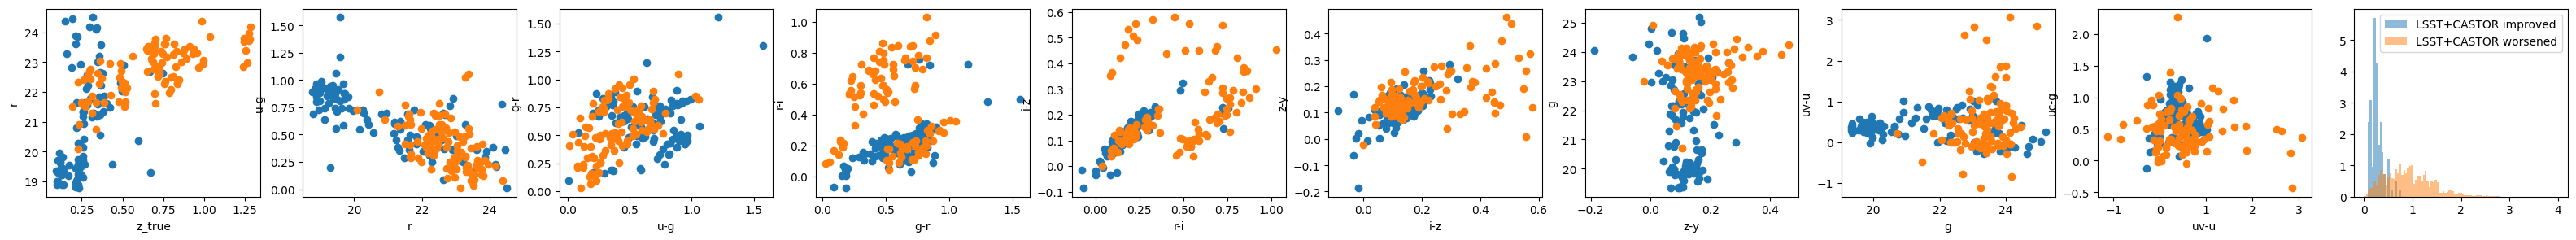

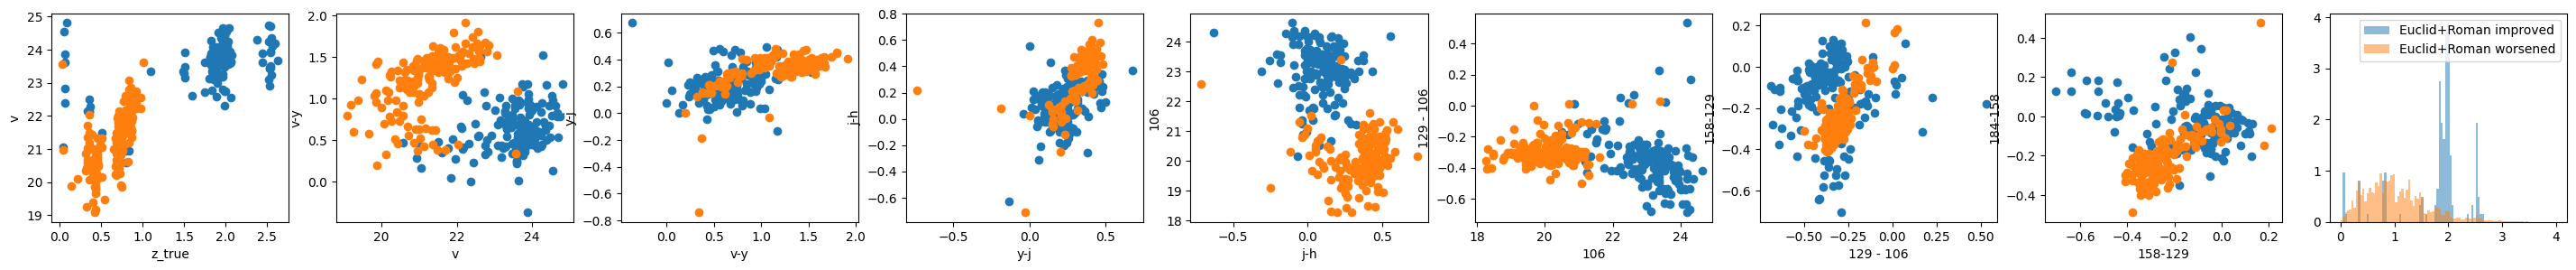

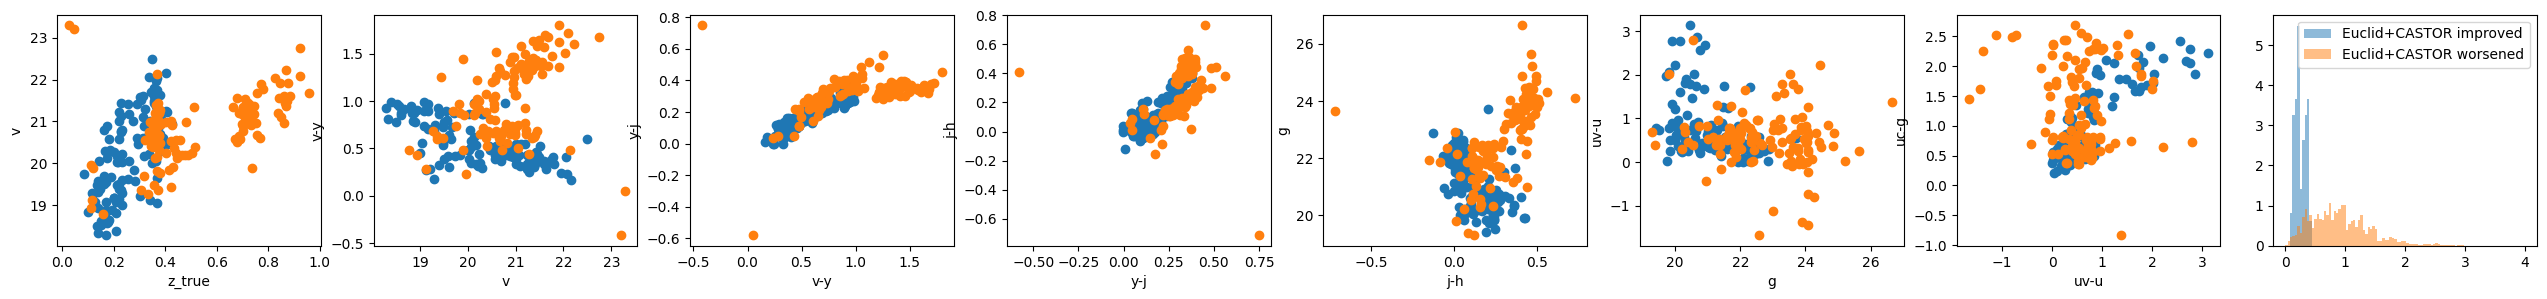

In [47]:
for j, os in enumerate(['LSST+CASTOR', 'Euclid+Roman', 'Euclid+CASTOR']):
    tot_plots = len(catalogs[os].columns)
    fig, ax = plt.subplots(1, tot_plots, figsize = (tot_plots * 4, 3))

    subset = catalogs[os][np.array(delta_tav_agg[os]) >= kld_hi[os]]

    for i, color_col in enumerate(catalogs[os].columns[:-1]):
      ax[i].scatter(subset[color_col], subset[subset.columns[i+1]])
      ax[i].set_xlabel(color_col)
      ax[i].set_ylabel(subset.columns[i+1])

    subset = catalogs[os][np.array(delta_tav_agg[os]) <= kld_lo[os]]

    for i, color_col in enumerate(catalogs[os].columns.values[:-1]):
      ax[i].scatter(subset[color_col], subset[subset.columns[i+1]])

    ax[i+1].hist(np.array(catalogs[os]['z_true'])[improved_indexes[os]], bins=np.linspace(0, 4, 100), label = os+' improved', alpha=0.5, density=True)
    ax[i+1].hist(np.array(catalogs[os]['z_true'])[worsened_indexes[os]], bins=np.linspace(0, 4, 100), label = os+' worsened', alpha=0.5, density=True)

    ax[i+1].legend()

In [70]:
for os in ['LSST+CASTOR', 'Euclid+Roman', 'Euclid+CASTOR']:
  print('improved for {}'.format(os))
  print(np.array(improved[os]).flatten()[np.argsort(improved[os])][0:10])
  print(np.array(improved_indexes[os]).flatten()[np.argsort(improved[os])][0:10])


  print('worsened for {}'.format(os))
  print(np.array(worsened[os]).flatten()[np.argsort(worsened[os])][0:10])
  print(np.array(worsened_indexes[os]).flatten()[np.argsort(worsened[os])][0:10])

improved for LSST+CASTOR
[26.744036 26.761179 26.934559 26.938515 26.970774 27.10555  27.13158
 27.18774  27.255419 27.278727]
[78350  6975 74295 56185 49608 69764 97881 58172  4461 28920]
worsened for LSST+CASTOR
[-7.9109387 -7.8410325 -7.078831  -6.9909883 -6.926186  -6.7869267
 -6.728232  -6.5743523 -6.215499  -6.166934 ]
[72 84 93 14 49 15 22 56 68 12]
improved for Euclid+Roman
[15.698767 15.708079 15.751795 15.7744   15.869194 15.897686 15.917312
 15.934699 15.95449  15.995629]
[ 93779   5610 144755  49893 117115 124782 152041 121827  63942  26429]
worsened for Euclid+Roman
[-2.766252  -2.591992  -2.584612  -2.4859912 -2.47784   -2.4148185
 -2.396423  -2.3760781 -2.3595247 -2.3386345]
[ 15 128  82   8  79  48  71 126  26 125]
improved for Euclid+CASTOR
[39.855164 39.90333  39.95764  39.996174 40.06208  40.164303 40.30716
 40.346874 40.419758 40.464012]
[108069 107161  71460  19070  58559  31568 120904  84535 117634  46079]
worsened for Euclid+CASTOR
[-3.1725996 -3.0414715 -2.89443

In [87]:
catalogs['LSST+CASTOR'].iloc[np.array(improved_indexes['LSST+CASTOR']).flatten()[np.argsort(improved['LSST+CASTOR'])]].index

Index([752211,  72693, 714543, 544307, 479141, 672915, 920324, 562343,  49319,
       278223,
       ...
       558758, 321496, 303687, 924675, 938539, 592223, 582878, 797075, 673422,
       163785],
      dtype='int64', name='CASTOR_ID', length=104)

In [65]:
np.array(worsened_indexes['Euclid+CASTOR']).flatten()[np.argsort(worsened['Euclid+CASTOR'])]

array([ 73,  76,  81,  38,   6,  16,  24,  53,  25,   7,  96,  83,  92,
        34,  82,  60,   8, 116,  37,   9, 121, 115,  98,  31,  44, 101,
       113,  48, 107,  45,  20,  65,  36,  80,  58,  29,  41, 110, 117,
        15, 103,  59,  74,  79,   2, 111,   1,   3,  66,  49,  47,  89,
        55, 114,  21,  40, 108,  99,  95,  57,  97,  90,  10,  39,  35,
        54,  52,  67,  75,   5,  69, 112,  50,  17,  18, 118, 105,  56,
        91,  13,  43,  11,  87,  30, 119,  23,  64,  93,  33,  22,  86,
        42,   0,  78,  94,  68,  71,  28,  19,  32, 100,  88,  27,  77,
        84,  46,  62,  70, 106,  12,  85, 120, 109, 104,  26,   4, 102,
        14,  63,  61,  51,  72])